# Replication of Lewis et al.(2022) Results

In this notebook, I replicate the results for Lewis et al. (2022) using FCR package. 

The following regresion is cosidered. 

\begin{equation}
\text { democracy }_{i t}=\beta_1 \text { democracy }_{i t-1}+\beta_2 \operatorname{logGDP} c_{i t-1}+\alpha_{g_{i t}}+v_{i t}
\end{equation}

The data is avaliable in [Bonhomme's website](https://sites.google.com/site/stephanebonhommeresearch/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings
import os
import sys
sys.path.append(os.getcwd()+"/fcr")
warnings.filterwarnings('ignore')

## Data

In [2]:
# import data
data = loadmat('final_data.mat')

# assign depedent variables and covariates
y = data['dem'].flatten()
Z = data['ldem_linc']
timed = np.tile(np.arange(7),90) # time dimension of the data

## Estimate FCR

In [ ]:
# import FCR package
from fcr import FCR

# define model
fcr_model = FCR(m=1.01,G=4)

#### Option 1: with data matrices

In [3]:
# estimation
fcr_model.estimate(y=y, timed=timed, Z=Z, grouped_time_FE=True, parallel=True, n_startingVal=100);

#### Option 2: with data frame and column names

In [ ]:
# create data frame
df = pd.DataFrame(data=np.column_stack((y,Z,timed)), columns=['dem','ldem','linc','timed'])

# estimation
fcr_model.estimate(df=df, y=['dem'], timed=['timed'], Z=['ldem','linc'], grouped_time_FE=True, parallel=True, n_startingVal=100);

In [4]:
# show the summary of the results
results_table = fcr_model.summarize()
results_table.head()

,Parameter,Estimate,Std Error,t-stat,Pr(>|t|),CI
0,theta_00,-0.596,0.085,-7.047,0.00,"(-0.735, -0.457)"
1,theta_01,-0.356,0.101,-3.522,0.00,"(-0.522, -0.19)"
2,theta_02,-0.242,0.104,-2.323,0.01,"(-0.413, -0.071)"
3,theta_03,-0.076,0.073,-1.037,0.15,"(-0.195, 0.044)"
4,theta_04,-0.080,0.068,-1.175,0.12,"(-0.191, 0.032)"


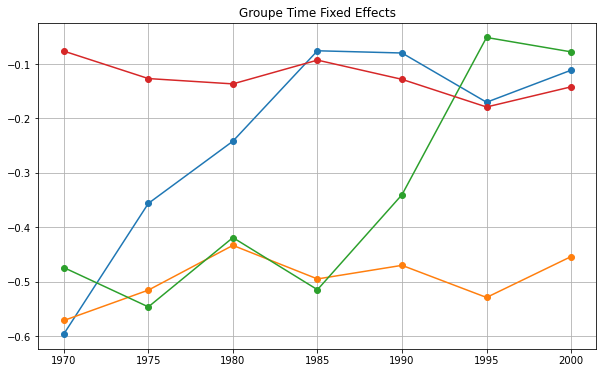

In [5]:
grouped_time_fe = fcr_model.grouped_time_FE()
years = [1970,1975,1980,1985,1990,1995,2000]

plt.figure(figsize=(10,6))
plt.plot(years, grouped_time_fe.T, marker='o')
plt.title('Groupe Time Fixed Effects')
plt.grid()
plt.show()

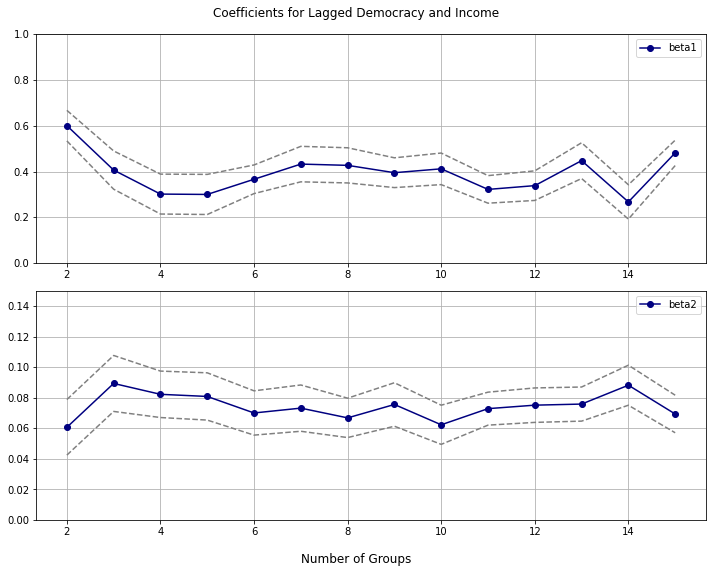

In [6]:
# max number of groups
Gbar = 15

# homogenous coefficients
beta1 = np.zeros(Gbar-1) # lag democracy
beta1_ci = np.zeros((Gbar-1,2))
beta2 = np.zeros(Gbar-1) # lag gdp
beta2_ci = np.zeros((Gbar-1,2))
for G in range(2,Gbar+1):
    
    # define model
    fcr_model = FCR(m=1.01,G=G)

    # estimation
    fcr_model.estimate(y=y, timed=timed, Z=Z, grouped_time_FE=True, parallel=True, n_startingVal=100)
    
    # homogenous coefficient estimates
    coefs = fcr_model.coef()
    homo_coefs = coefs[-Z.shape[1]:] # last Z.shape[1] elements
    beta1[G-2] = homo_coefs[0]
    beta2[G-2] = homo_coefs[1]
    
    # confidence intervals
    ci = fcr_model.confint()
    homo_ci = ci[-Z.shape[1]:,:]
    beta1_ci[G-2,:] = homo_ci[0,:] 
    beta2_ci[G-2,:] = homo_ci[1,:] 

fig, axs = plt.subplots(2)
fig.set_figwidth(10)
fig.set_figheight(8)
axs[0].plot(range(2,Gbar+1), beta1, marker='o', label='beta1', color='navy')
axs[0].plot(range(2,Gbar+1), beta1_ci, linestyle='--',color='grey')
axs[0].legend()
axs[0].grid()
axs[0].set_ylim([0,1])
axs[1].plot(range(2,Gbar+1), beta2, marker='o', label='beta2', color='navy')
axs[1].plot(range(2,Gbar+1), beta2_ci, linestyle='--',color='grey')
axs[1].legend()
axs[1].grid()
axs[1].set_ylim([0,0.15])
#axs[1].set_xlabel('Number of Groups')
fig.supxlabel('Number of Groups')
fig.suptitle('Coefficients for Lagged Democracy and Income')
plt.tight_layout()
plt.show()

## Choosing G (number of groups)

The package provides BIC for selecting optimal number of groups.

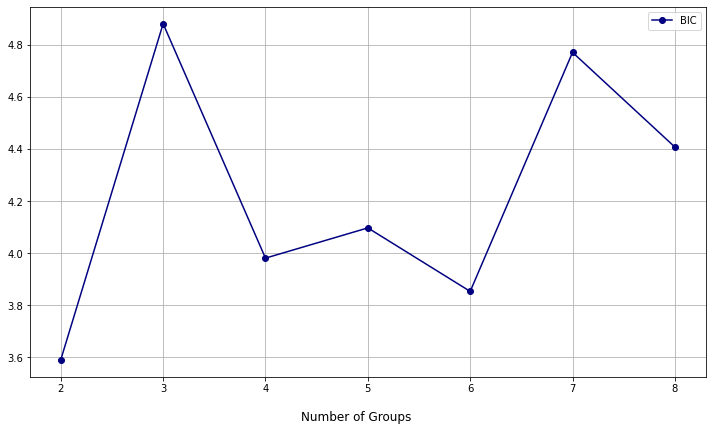

In [7]:
# max number of groups
Gbar = 8

# compute BIC
bic = np.zeros(Gbar-1)
for G in range(2,Gbar+1):
    
    # define model
    fcr_model = FCR(m=1.01,G=G)

    # estimation
    fcr_model.estimate(y=y, timed=timed, Z=Z, grouped_time_FE=True, parallel=True, n_startingVal=100)
    
    # information criteria
    bic[G-2] = fcr_model.bic()

fig, ax = plt.subplots(1)
fig.set_figwidth(10)
fig.set_figheight(6)
ax.plot(range(2,Gbar+1), bic, marker='o', label='BIC', color='navy')
ax.legend()
ax.grid()
fig.supxlabel('Number of Groups')
plt.tight_layout()
plt.show()